## Cal-CRAI metric: SPEI
This notebook briefly walks through how to calculate the `% change in probability that a water year is classified as having Moderate, Severe, or Extreme drought conditions via Standardized Precipitation Evapotranspiration Index (SPEI)` metric with FFWI data from the Cal-Adapt: Analytics Engine. This notebook may be expanded upon for inclusion in cae-notebooks in the future. **SPEI** will be added as an available data metric to climakitae as a part of this development. 

**Order of operations:**

1. Read data in
2. Calculate base function (FFWI, SPEI, warm nights, etc.)
3. Calculate chronic
4. Calculate delta signal
5. Reprojection to census tracts
6. Min-max standardization
7. Export data
8. Generate metadata (via Cal-CRAI environment, not AE)

**Runtime**: This notebook takes approximately ~1 hours to run due to data size, warming levels, and reprojection steps.

**References**: 
1. S. M. Vicente-Serrano, S. Beguería, and J. I. López-Moreno, “A Multiscalar Drought Index Sensitive to Global Warming: The Standardized Precipitation Evapotranspiration Index,” Journal of Climate, vol. 23, no. 7, pp. 1696–1718, Apr. 2010, doi: 10.1175/2009JCLI2909.1.
2. George H. Hargreaves and Zohrab A. Samani. Reference Crop Evapotranspiration from Temperature. Applied engineering in agriculture, 1(2):96–99, 1985. PubAg AGID: 5662005. doi:10.13031/2013.26773
3. https://xclim.readthedocs.io/en/stable/indices.html#xclim.indices.potential_evapotranspiration
4. https://xclim.readthedocs.io/en/stable/indices.html#xclim.indices.standardized_precipitation_evapotranspiration_index

Variables:
1. Daily Water Budget, which is the difference between:
    - Daily precipitation and
    - Daily potential evapotranspiration, derived from some combo of the following, depending on method:
       - Daily Min Temperature
       - Daily Max Temperature
       - Daily Mean Temperature
       - Relative Humidity
       - Surface Downwelling Shortwave Radiation
       - Surface Upwelling Shortwave Radiation
       - Surface Downwelling Longwave Radiation
       - Surface Upwelling Longwave Radiation
       - 10m Wind Speed
       
       *we will be using the Hargreaves and Samani (1985) version, so we use daily min and max temperatures*
2. Calibration Daily Water Budget
    - Can be computed from Daily Water Budget over a given "calibration" time period
    
### Step 0: Import libraries

In [20]:
import climakitae as ck
from climakitae.explore import warming_levels 
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.util.utils import read_ae_colormap
import xarray as xr
import pandas as pd
from xclim.indices import (
    potential_evapotranspiration, 
    standardized_precipitation_evapotranspiration_index,
    standardized_precipitation_index
)
import numpy as np
import geopandas as gpd

# import os
# import sys
# import s3fs
# import boto3
# sys.path.append(os.path.expanduser('../../'))
# from scripts.utils.file_helpers import upload_csv_aws

import cartopy.crs as ccrs

crs = ccrs.LambertConformal(
    central_longitude=-70, 
    central_latitude=38, 
    false_easting=0.0, 
    false_northing=0.0,  
    standard_parallels=[30, 60], 
    globe=None, 
    # cutoff=-30
)
div_cmap = read_ae_colormap(
    cmap="ae_diverging", cmap_hex=True
)  
cmap = read_ae_colormap(
    cmap="ae_orange", cmap_hex=True
)

In [2]:
sims_wl = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_MIROC6_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_EC-Earth3_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_TaiESM1_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
]
sims_hist = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1',
    'WRF_MIROC6_r1i1p1f1', 
    'WRF_EC-Earth3_r1i1p1f1',
    'WRF_TaiESM1_r1i1p1f1', 
]

sim_name_dict = dict(zip(sims_wl,sims_hist)) 

In [3]:
def reproject_to_tracts(ds_delta, ca_boundaries):
    # this step takes about 12 minutes with 3km data (~1 min with 9km data)
    df = ds_delta.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x,df.y))
    gdf = gdf.set_crs(crs)
    gdf = gdf.to_crs(ca_boundaries.crs)
    
    ca_boundaries = ca_boundaries.set_index(['GEOID'])    

    clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how='left')
    clipped_gdf = clipped_gdf.drop(['index_right'], axis=1)
    clipped_gdf = clipped_gdf.reset_index()[
        ["GEOID",f"{ds_delta.name}","geometry"]]
    ### some coastal tracts do not contain any land grid cells ###
    
    # aggregate the gridded data to the tract level
    clipped_gdf_diss = clipped_gdf.reset_index().dissolve(
        by='GEOID', aggfunc='mean')
    clipped_gdf_diss = clipped_gdf_diss.rename(
        columns={f"{ds_delta.name}_right":
                 ds_delta.name}
    )
    
    # separate tracts with data from tracts without data
    clipped_gdf_nan = clipped_gdf_diss[np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_nan = clipped_gdf_nan[["geometry",ds_delta.name]]
    clipped_gdf_valid = clipped_gdf_diss[~np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_valid = clipped_gdf_valid[["geometry",ds_delta.name]]

    # compute the centroid of each tract
    clipped_gdf_nan["centroid"] = clipped_gdf_nan.centroid
    clipped_gdf_nan = clipped_gdf_nan.set_geometry("centroid")
    clipped_gdf_valid["centroid"] = clipped_gdf_valid.centroid
    clipped_gdf_valid = clipped_gdf_valid.set_geometry("centroid")
    
    # fill in missing tracts with values from the closest tract
    # in terms of distance between the tract centroids
    clipped_gdf_filled = clipped_gdf_nan.sjoin_nearest(clipped_gdf_valid, how='left')
    clipped_gdf_filled = clipped_gdf_filled[["geometry_left",f"{ds_delta.name}_right"]]
    clipped_gdf_filled = clipped_gdf_filled.rename(columns={
        "geometry_left":"geometry", f"{ds_delta.name}_right":ds_delta.name
    })
    clipped_gdf_valid = clipped_gdf_valid.drop(columns="centroid")
 
    # concatenate filled-in tracts with the original tract which had data
    gdf_all_tracts = pd.concat([clipped_gdf_valid,clipped_gdf_filled])

    return gdf_all_tracts


def min_max_standardize(df, col):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    max_value = df[col].max()
    min_value = df[col].min()

    # Get min-max values, standardize, and add columns to df
    prefix = col # Extracting the prefix from the column name
    df[f'{prefix}_min'] = min_value
    df[f'{prefix}_max'] = max_value
    df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))

    # note to add checker to make sure new min_max column values arent < 0 > 1
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] < 0] = 0
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] > 1] = 1
    
    return df

### Step 1: Retrieve data
We need to calculate:
* 30 year centered around 2.0C warming level (SSP3-7.0)
* Historical baseline 1981-2010 (Historical Climate)

Note: the 3km data is too large to work with for all of CA for warming level conditions. Working with 45km for now.

#### Step 1a) Chronic data (2.0°C WL)

In [4]:
wl = warming_levels()

In [5]:
# max air temperature
wl.wl_params.timescale = "daily"
wl.wl_params.downscaling_method = "Dynamical"
wl.wl_params.resolution = '3 km'
wl.wl_params.variable = 'Maximum air temperature at 2m'
wl.wl_params.area_subset = "CA counties" ## just for testing
wl.wl_params.cached_area = ["Sacramento County"] ## just for testing
wl.wl_params.warming_levels = ["2.0"]
wl.wl_params.anom = "No"
wl.calculate()
ds_maxT = wl.sliced_data["2.0"] # grab 2.0 degC data
ds_maxT = ds_maxT.sel(all_sims = list(sim_name_dict.keys()))
ds_maxT = add_dummy_time_to_wl(ds_maxT) # add time dimension back in, as this is removed by WL and is required for xclim functionality

# min air temperature
wl.wl_params.variable = 'Minimum air temperature at 2m'
wl.calculate()
ds_minT = wl.sliced_data["2.0"] # grab 2.0 degC data
ds_minT = ds_minT.sel(all_sims = list(sim_name_dict.keys()))
ds_minT = add_dummy_time_to_wl(ds_minT) # add time dimension back in, as this is removed by WL and is required for xclim functionality

# precip
wl.wl_params.variable = 'Precipitation (total)'
wl.calculate()

ds_precip = wl.sliced_data["2.0"]
ds_precip = ds_precip.sel(all_sims = list(sim_name_dict.keys()))
ds_precip = add_dummy_time_to_wl(ds_precip)
ds_precip = ds_precip.clip(min=1.)

Computing each warming level:   0%|          | 0/1 [00:00<?, ?it/s]

Processing data to read 220.55 MB of data into memory... 
[########################################] | 100% Completed | 31.33 s
Complete!


Computing each warming level:   0%|          | 0/1 [00:00<?, ?it/s]

Processing data to read 220.55 MB of data into memory... 
[########################################] | 100% Completed | 33.47 s
Complete!


Computing each warming level:   0%|          | 0/1 [00:00<?, ?it/s]

Processing data to read 220.55 MB of data into memory... 
[########################################] | 100% Completed | 20.68 s
Complete!


In [6]:
## Retrieve historical baseline data (1981-2010)
selections = ck.Select()
selections.timescale = 'daily'
selections.variable = 'Maximum air temperature at 2m'
selections.area_subset = "CA counties" ## just for testing
selections.cached_area = ["Sacramento County"] ## just for testing
selections.scenario_historical=['Historical Climate']
selections.area_average = 'No'
selections.time_slice = (1981,2010) 
selections.resolution = '3 km'
max_t_hist = selections.retrieve()
max_t_hist = max_t_hist.sel(simulation=sims_hist)

# now min temperature
selections.variable = 'Minimum air temperature at 2m'
min_t_hist = selections.retrieve()
min_t_hist = min_t_hist.sel(simulation=sims_hist)

# also need precip
selections.variable = 'Precipitation (total)'
precip_hist = selections.retrieve()
precip_hist = precip_hist.clip(min=1.)
precip_hist = precip_hist.sel(simulation=sims_hist)

## Step 2: Calculate metric
* % change in probability that a water year is classified as having Moderate, Severe, or Extreme drought conditions via SPEI
* GWL model-mean # drought years/30 - historical model-mean # drought years/30)is GWL model-mean # drought years/30 - historical model-mean # drought years/30)

In [7]:
def calculate_wb(tasmin, tasmax, precip):
    # first calculate PET
    pet = potential_evapotranspiration(tasmin=tasmin, tasmax=tasmax, method='HG85')
    pet = pet * (60*60*24) # convert from per second to per day
    pet.attrs['units'] = 'mm'
    
    # calculate water budget
    wb = precip - pet
    wb.attrs['units'] = 'mm/day'
    
    # handing for simulation/all_sims dimension between historical and wl data
    da_list = []
    
    if 'simulation' in wb.dims:
        for sim in wb.simulation.values:
            da = wb.sel(simulation=sim)
            wb_min = da.min().values
            da = da+abs(wb_min)
            da_list.append(da)
    
    elif 'all_sims' in wb.dims:
        for sim in wb.all_sims.values:
            da = wb.sel(all_sims=sim)
            wb_min = da.min().values
            da = da+abs(wb_min)
            da_list.append(da)
            
    wb = xr.concat(da_list, dim='simulation')
    wb = wb.chunk(dict(time=-1)).compute()
    
    return wb

def calculate_spei(wb, wb_cal):
    
    # finally calculate 3 month SPEI
    spei = standardized_precipitation_evapotranspiration_index(
        wb=wb, 
        wb_cal=wb_cal,
        freq='MS',
        window=3,
        dist='gamma',
        method='APP',
    )
    
    # assign water year coordinate
    water_year = (spei.time.dt.month >= 10) + spei.time.dt.year
    spei.coords['water_year'] = water_year
    
    return spei

In [8]:
# Calculate water budget for historical data.
# This will also serve as our calibration water budget for the warming levels data.
wb_hist = calculate_wb(
    tasmin = min_t_hist,
    tasmax = max_t_hist,
    precip = precip_hist
)

In [9]:
# Calculate water budget for warming levels data.
wb_wl = calculate_wb(
    tasmin = ds_minT,
    tasmax = ds_maxT,
    precip = ds_precip
)

In [10]:
# Calculate historical SPEI using itself as the calibration water budget
spei_hist = calculate_spei(
    wb = wb_hist,
    wb_cal = wb_hist
)

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [11]:
# Calculate warming levels SPEI using the historical water budget for the calibration water budget
spei_wl = calculate_spei(
    wb = wb_wl,
    wb_cal = wb_hist
)

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


Count number of water years featuring 6 or more months with SPEI < -1 (ie, 6 or more dry months in a year)

In [12]:
# now calculate number of drought years from SPEI
def drought_yrs(spei):   
    mod_dry_thresh = -1.0
    drought_duration_thresh = 6 # 3 months = short-term drought; 6+ = long-term
    num_dry_months = (spei <= mod_dry_thresh).groupby('water_year').sum('time')
    num_dry_years = (num_dry_months >= drought_duration_thresh).sum('water_year')
    # take model average
    num_dry_years_avg = num_dry_years.mean(dim=['simulation']).squeeze() 
    
    # make a nan mask
    nan_mask = spei.isel(simulation=0, time=-1).squeeze()
    # nan out grid points outside of the domain
    num_dry_years_avg = xr.where(np.isnan(nan_mask), x=np.nan, y=num_dry_years_avg)
    
    return num_dry_years_avg

In [34]:
# Count the number of drought years for historical and warming level periods
drought_yrs_hist = drought_yrs(spei_hist)
drought_yrs_wl = drought_yrs(spei_wl)

### Step 2: Calculate delta signal
Difference between chronic (at 2.0°C warming level) and historical baseline (1981-2010)

In [15]:
ds_delta = drought_yrs_wl - drought_yrs_hist
ds_delta.name = "change_in_drought_years" # assign name so it can convert to pd.DataFrame

In [16]:
ds_delta.min().values, ds_delta.max().values # change over time

(array(-1.), array(3.25))

### Step 3: Reproject and aggregate to tracts

In [29]:
census_shp_dir = "tl_2021_06_tract.shp"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries = ca_boundaries[["COUNTYFP","GEOID","geometry"]]
# isolate sacramento county
ca_boundaries = ca_boundaries[ca_boundaries["COUNTYFP"]=='067']
ca_boundaries = ca_boundaries.to_crs(crs=3310) 

In [30]:
drought_df = reproject_to_tracts(ds_delta, ca_boundaries) 
drought_df

,geometry,change_in_drought_years
GEOID,,
06067001701,"POLYGON ((-125051.876 60809.257, -125049.550 6...",1.50
06067002900,"POLYGON ((-126561.871 59930.673, -126244.437 5...",1.50
06067003001,"POLYGON ((-124296.100 59100.247, -124162.031 5...",1.50
06067003101,"POLYGON ((-124317.939 58141.606, -124315.753 5...",1.75
06067003204,"POLYGON ((-124306.647 57486.187, -124118.577 5...",1.75
...,...,...
06067009646,"POLYGON ((-126650.928 41793.455, -126549.811 4...",1.75
06067009647,"POLYGON ((-126719.851 42705.371, -126688.573 4...",1.75
06067009648,"POLYGON ((-125700.626 43146.413, -125697.721 4...",2.00


<AxesSubplot: >

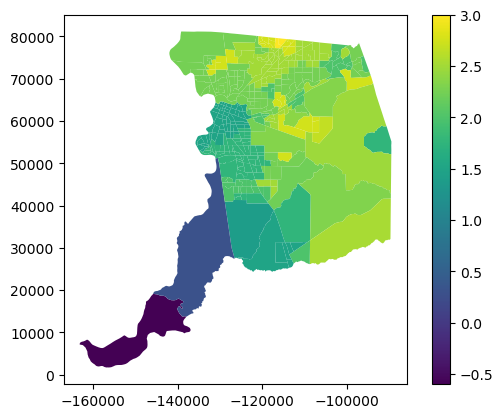

In [33]:
drought_df.plot(column="change_in_drought_years", legend=True)

In [35]:
drought_data_std = min_max_standardize(drought_df, col=ds_delta.name)
drought_data_std

,geometry,change_in_drought_years,change_in_drought_years_min,change_in_drought_years_max,change_in_drought_years_min_max_standardized
GEOID,,,,,
06067001701,"POLYGON ((-125051.876 60809.257, -125049.550 6...",1.50,-0.6,3.0,0.583333
06067002900,"POLYGON ((-126561.871 59930.673, -126244.437 5...",1.50,-0.6,3.0,0.583333
06067003001,"POLYGON ((-124296.100 59100.247, -124162.031 5...",1.50,-0.6,3.0,0.583333
06067003101,"POLYGON ((-124317.939 58141.606, -124315.753 5...",1.75,-0.6,3.0,0.652778
06067003204,"POLYGON ((-124306.647 57486.187, -124118.577 5...",1.75,-0.6,3.0,0.652778
...,...,...,...,...,...
06067009646,"POLYGON ((-126650.928 41793.455, -126549.811 4...",1.75,-0.6,3.0,0.652778
06067009647,"POLYGON ((-126719.851 42705.371, -126688.573 4...",1.75,-0.6,3.0,0.652778
06067009648,"POLYGON ((-125700.626 43146.413, -125697.721 4...",2.00,-0.6,3.0,0.722222
